# Data chunking

The previous section about [computations with large datasets](https://acdguide.github.io/BigData/computations.html) shows diagrams with various operations computed on chunks of data. Here, we will go into more depth on what chunking is, why it matters, and some real-world examples.

In [1]:
## This is setup for the plots later on in the notebook - on the website this
## cell (and the cells making the diagrams) is hidden by default, using the 'hide-input' cell tag

import matplotlib
import matplotlib.pyplot as plt
import numbers
import numpy

def draw_chunks(ax, size = (10, 8), nchunks = (5, 2), chunk_size = None, chunk_color = None):
    """
    Draw a chunk diagram
    
    Args:
        ax:          matplotlib.pyplot axis to draw on
        size:        size of the array (x, y)
        nchunks:     number of chunks (x, y)
        chunk_size:  size of each chunk (x, y) (default size/nchunks)
        chunk_color: colour of each chunk (array with shape nchunks)
    """
    
    spacing = 0.1
    
    if chunk_size is None:
        chunk_size = (None, None)
        
    if chunk_color is None:
        chunk_color = numpy.full(nchunks, 'wheat')
    else:
        chunk_color = numpy.asarray(chunk_color)
        
    # Fill in None values
    chunk_size = tuple(chunk_size[i] if chunk_size[i] is not None else size[i] / nchunks[i]
                        for i in range(2))
    
    if isinstance(chunk_size[0], numbers.Number):
        xsize = numpy.full(nchunks[0], chunk_size[0]) - spacing
    else:
        xsize = numpy.asarray(chunk_size[0]) - spacing
        
    if isinstance(chunk_size[1], numbers.Number):
        ysize = numpy.full(nchunks[1], chunk_size[1]) - spacing
    else:
        ysize = numpy.asarray(chunk_size[1]) - spacing

                        
    # Chunk cell centre
    xc = (numpy.arange(nchunks[0], dtype='f') + 0.5) * (size[0] / nchunks[0])
    yc = (numpy.arange(nchunks[1], dtype='f') + 0.5) * (size[1] / nchunks[1])
    
    for ii in range(nchunks[0]):
        for jj in range(nchunks[1]):
            box = matplotlib.patches.Rectangle((xc[ii] - xsize[ii]/2,
                                                yc[jj] - ysize[jj]/2),
                                               xsize[ii],
                                               ysize[jj], 
                                               facecolor=chunk_color[ii,jj], edgecolor='black')
            
            ax.add_patch(box)
            
    ax.set_xbound(0, size[0])
    ax.set_ylim(0, size[1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    

## What is data chunking?

Large data arrays are composed of smaller units which are called *chunks*. This is why some software, like xarray, can load data lazily, i.e. load into memory only the data chunks it needs to perfom a specific operation. 
All data stored in netcdf files have been written in chunks, following some chunking strategy. NCO has a list of different chunking policies that you can apply to write a netcdf file. The most common and default approach is to prioritise accessing the data as a grid, so that retrieving all grid points at one timestep will require loading only 1 or few chunks at one time. On the other side this strategy means that often time has a chunk size of 1, i.e. each timestep is on a different chunk, which means that when we want to analysis a timeseries from the same data we will be loading the entire dataset when we are expecting to only loading one grid point. 
Dask has a comprehensive but accessible [blog introducing chunks](https://blog.dask.org/2021/11/02/choosing-dask-chunk-sizes), including how to choose an optimal chunk size in dask and how to align chunks to the original file chunks.


## Why chunking matters?
Chunks allow to manage memory more efficiently, and to create optimal parallelisation configurations. However, if the chunking is done in a suboptimal way, it can sometimes lead to slower computations or other negative performance outputs.
For more details on why chunking can have significant implications for performance of both data reading/writing and data computation, see [this article](https://www.unidata.ucar.edu/blogs/developer/en/entry/chunking_data_why_it_matters).

{ref}`cdo` and {ref}`nco` also offer some useful.

http://nco.sourceforge.net/nco.html#Timeseries-Reshaping-mode_002c-aka-Splitting

## Chunking in the real world

Examples will be added here soon!

### Simple function to retrieve file chunks

[This blog](https://climate-cms.org/posts/2021-07-29-coarsen_climatology.html) includes a simple function to retrieve a netcdf file chunks.

### Using map_blocks

Dask provides the dask.array.map_blocks() function that allows you to run a function on every chunk of an array.
The last section of [this blog](https://climate-cms.org/posts/2021-11-24-api.html?highlight=chunk#pure-dask-advanced) shows an example of how to use map_blocks()

### Chunks effects on parallel computations with dask

This [parallel training](https://coecms-training.github.io/parallel/dask-intro.html) has many references to chunks and their effects on computation in its dask and case studies sections.
!!!Any more example on map_blocks would be brillinat as it is hard to find them!

## Common Tasks

The chunking illustrations in this section show approximately how these operations are done in Xarray + Dask, to give an idea of their complexity when working with large datasets and a basic idea of how these operations can be implemented manually. Normal arrows mean one chunk on the left gets mapped to one chunk on the right, a left square bracket means the number of chunks is reduced after this operation, a right square bracket means the number of chunks is increased. The most intensive operations are rechunking, as these require a lot of data in-memory, which are indicated with a large square bracket on both left and right.

A *'reduce'* operation lowers the number of dimensions (e.g. a mean along the time axis). A *'map'* operation keeps the array size the same (e.g. a rolling mean)

Tasks can be combined - you might calculate a climatology of 90th percentiles for each day in the year, or resample daily data to monthly maximums.

### Min / Max / Mean / Stddev

Functions like these are pretty simple to calculate regardless of dataset size, as they don't require the entire dataset to be in memory. You can just loop over the dimension to be reduced calculating value so far up to that step

In pseudocode (in Python you're better off using `data.min(axis=0)`, as that's optimised compared to a loop)

```python
for t in range(data.shape[0]):
    out_min = np.minimum(out_min, data[t,...])
    out_max = np.maximum(out_max, data[t,...])
    out_sum = out_sum + data[t,...]
    
out_mean = out_sum / data.shape[0]
```

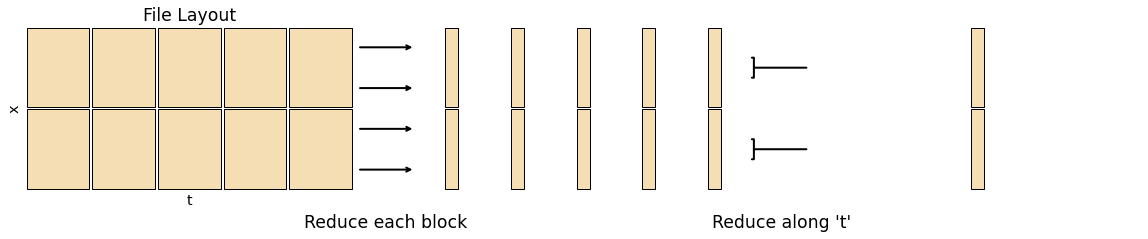

In [2]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(20,3))

draw_chunks(axs[0])
axs[0].set_xlabel('t', fontsize='x-large')
axs[0].set_ylabel('x', fontsize='x-large')
axs[0].set_title('File Layout', fontsize='xx-large')

draw_chunks(axs[1], chunk_size=(0.5, None))

draw_chunks(axs[2], nchunks=(1, 2), chunk_size=(0.5, None))

for i in range(4):
    h = 1/4 * (i+0.5)
    conn = matplotlib.patches.ConnectionPatch((1.02, h), (-0.02, h), axs[0].transAxes, axs[1].transAxes, arrowstyle='->', linewidth=2)
    fig.add_artist(conn)

for i in range(2):
    h = 1/2 * (i+0.5)
    conn = matplotlib.patches.ConnectionPatch((1.02, h), (-0.02, h), axs[1].transAxes, axs[2].transAxes, arrowstyle=']-', linewidth=2)
    fig.add_artist(conn)
    
fig.add_artist(matplotlib.text.Text(0.375, -0.05, "Reduce each block", fontsize='xx-large',  ha='center', transform=fig.transFigure))
fig.add_artist(matplotlib.text.Text(0.65, -0.05, "Reduce along 't'", fontsize='xx-large',  ha='center', transform=fig.transFigure))

None

**Resources**

 - **Numpy** [statistics functions](https://numpy.org/doc/stable/reference/routines.statistics.html)
 - **Dask** also has optimised implementations for its arrays, e.g. [dask.array.mean](https://docs.dask.org/en/latest/array-api.html#dask.array.mean)
 - **Xarray** functions work the same as numpy, but keep the xarray metadata and you can use dimension names instead of axis numbers. [Weighted](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.weighted.html) operations are also available
 - **CDO** `cdo --operators | grep fld` will give a list of basic statistics operations
 
**Demonstrations**
 - Python - [Weighted Mean](http://xarray.pydata.org/en/stable/examples/area_weighted_temperature.html) from Xarray documentation

### Percentiles / Median

Percentiles are much trickier to calculate than basic statistics. To find the percentiles for a grid cell, you have to load the whole timeseries into memory, sort that timeseries, then find the value $N\%$ along that sorted timeseries. For a large dataset this becomes very costly, especially since most datasets are stored in a way optimised for loading the whole domain at a single time rather than the timeseries at a single point.

When there are `NAN` values in the timeseries percentiles become even harder to calculate, as the `NAN` values must be discarded by the algorithm.

There are approximate ways to compute percentiles that don't require the whole dataset in memory such as [T-digest](https://github.com/tdunning/t-digest)

Memory concerns are less of an issue when calculating percentiles on a subset of the data - e.g. when calculating climatologies.

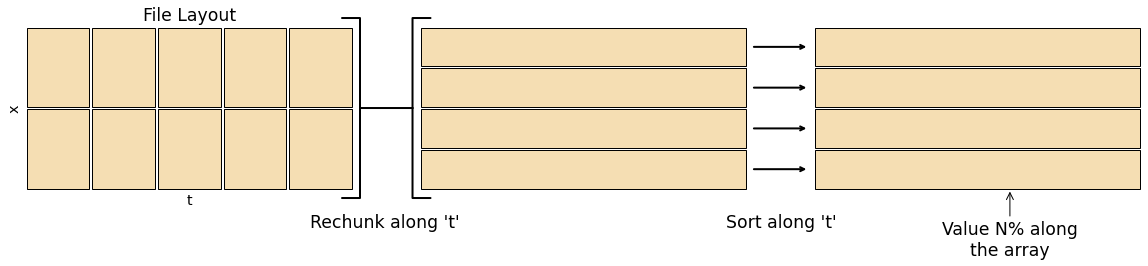

In [3]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(20,3))

draw_chunks(axs[0])
axs[0].set_xlabel('t', fontsize='x-large')
axs[0].set_ylabel('x', fontsize='x-large')
axs[0].set_title('File Layout', fontsize='xx-large')

draw_chunks(axs[1], nchunks=(1, 4))

draw_chunks(axs[2], nchunks=(1, 4))
axs[2].annotate('Value N% along\nthe array', (0.6, 0), (0.6, -0.4), 'axes fraction', 'axes fraction', fontsize='xx-large', arrowprops={'arrowstyle': '->'}, ha='center')

regrid_conn = matplotlib.patches.ConnectionPatch((1.02, 0.5), (-0.02, 0.5), axs[0].transAxes, axs[1].transAxes, arrowstyle=']-[', mutation_scale=90, linewidth=2)
fig.add_artist(regrid_conn)

for i in range(4):
    h = 1/4 * (i+0.5)
    sort_conn = matplotlib.patches.ConnectionPatch((1.02, h), (-0.02, h), axs[1].transAxes, axs[2].transAxes, arrowstyle='->', linewidth=2)
    fig.add_artist(sort_conn)
    
fig.add_artist(matplotlib.text.Text(0.375, -0.05, "Rechunk along 't'", fontsize='xx-large',  ha='center', transform=fig.transFigure))
fig.add_artist(matplotlib.text.Text(0.65, -0.05, "Sort along 't'", fontsize='xx-large',  ha='center', transform=fig.transFigure))

None